In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dataset=pd.read_csv("cleaned_data.csv")
#Removed Unnamed:0 column
dataset.drop("Unnamed: 0",axis=1,inplace=True)
dataset.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
#Separate dataframe into target variable and features
y=dataset.Exited
X=dataset.drop("Exited",axis=1)
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


In [5]:
#Now consider the categorical features of the dataset that need to be encoded 
cat_feature=X.select_dtypes(include='object').columns.to_list()
cat_feature
#Splitting into X ad y values
from sklearn.model_selection import train_test_split
random_state=10
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=random_state,
                                               stratify=dataset.Exited)
print(len(X_train),len(X_test))
print(len(y_train),len(y_test))

8000 2000
8000 2000


In [6]:
#Creating a preprocessing pipeline
#Objective:Scale the data and also encoding categorical value using SMOTE

#1-Call numerical features
#define num_colomn

num_columns=X.select_dtypes(include="number").columns.to_list()
num_features = [] 

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)

[0, 3, 4, 5, 6, 7, 8, 9]


In [7]:
#Perform same for categorical value
cat_features=[]
for i in cat_feature:
    location=X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features)  

[1, 2]


In [8]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbl_pipe
# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE


preprocess = make_column_transformer(
     (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 3, 4, 5, 6, 7, 8, 9]),
                                ('onehotencoder', OneHotEncoder(sparse=False),
                                 [1, 2])])

In [9]:
import xgboost as xgb
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  xgb.XGBClassifier(random_state=random_state))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 3, 4, 5, 6, 7, 8, 9]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [1, 2])])),
                ('smote', SMOTE(random_state=10)),
                ('xgbclassifier', XGBClassifier(random_state=10))])

In [10]:
xgb.XGBClassifier().get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [11]:
from sklearn.model_selection import GridSearchCV
param_grid = {'xgbclassifier__gamma': [0.5, 0.8, 1],
              'xgbclassifier__max_depth': [3, 4, 5, 6],
              'xgbclassifier__n_estimators': [50, 100, 200]
        }
grid = GridSearchCV(model, param_grid, verbose=3, cv= 5, n_jobs=4, scoring='f1_macro')
grid.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  2.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8,
                                                                          9]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [1,
                                                                          2])

In [12]:
#Check the best parameter and score
print(grid.best_params_)
print(grid.best_score_)

{'xgbclassifier__gamma': 1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 200}
0.7629398433834347


In [13]:
#Make rediction using the best paramter(grid)
y_pred=grid.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1593
           1       0.67      0.62      0.64       407

    accuracy                           0.86      2000
   macro avg       0.79      0.77      0.78      2000
weighted avg       0.86      0.86      0.86      2000

-----------------------------------------------------------------------


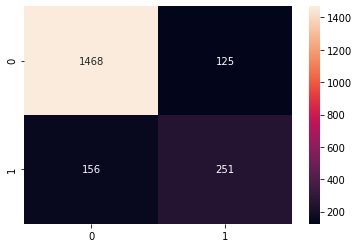

In [14]:
#Evaluate the mdoel using Confusion matrix,classification metrics
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm=confusion_matrix(y_test,y_pred)
cr=classification_report(y_test,y_pred)
print(cr)
print("-----------------------------------------------------------------------")
import seaborn as sns
sns.heatmap(cm,fmt="d",annot=True)

In [15]:
#Prediction on First 20 entries
print(f"Predicted classes: \t{list(y_pred[:20])}")
print(f"Actual Labels: \t\t{list(y_test[:20])}")

Predicted classes: 	[1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Actual Labels: 		[1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]


In [29]:
#Save the model using joblib
import joblib
# We are saving our grid model
filename = 'XGBoost_model2.sav'
joblib.dump(grid, filename)

['XGBoost_model2.sav']

In [30]:
#loading the model
xgb_model = joblib.load(filename)
print(xgb_model.score(X_test, y_test))

0.7768877106019227


In [31]:
#let's predict on new value
#X_test[:1]
pred_new = xgb_model.predict(X_test[:1])

In [32]:
print("the predicted is",pred_new)
print("the actual value is",list(y_test[:1]))

the predicted is [1]
the actual value is [1]


In [33]:
#Save it using pickle
import pickle
pickle.dump(grid,open("xgboost_2.pkl", "wb"))

In [38]:
pred_prob=grid.predict([[850,"Spain","Female",43,2,125510,1,1,1,79084]])
output='{0:.{1}f}'.format(pred_prob[0][1], 2)
output = str(float(output)*100)+'%'
if output>str(0.5):
    print("High chance of leaving with",output)
else:
    print("waek chance of leaving with",output)

High chance of leaving with 17.0%


In [30]:
output

'98.0%'

In [52]:
pred=grid.predict([[850,"Spain","Female",43,2,125510,1,1,1,79084]])
pred_prob=grid.predict_proba([[850,"Spain","Female",43,2,125510,1,1,1,79084]])
output='{0:.{1}f}'.format(pred_prob[0][1], 2)
output = str(float(output)*100)+'%'
if pred[0]==1:
    print("Problably leaving")
    print("high probability of",output)
else:
    print("Not leaving")
    print(" weak probability of",output)

Not leaving
 weak probability of 17.0%
